# Week 3

Data files not pickled - loading from original txt files.


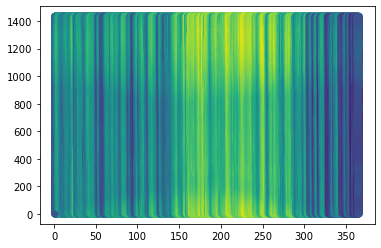

In [1]:
# Load the temperature data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
#import plotly.graph_objects as go
import itertools
# Converters


def timeconv(val, default_val=0):
    try:
        val = int(val)
        return np.floor_divide(val,100)*60 + np.mod(val,100)
    except ValueError:
        return default_val

def dateconv(val, default_val = 0):
    date = pd.to_datetime(val, format='%Y%m%d')
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    return (date - new_year_day).days + 1

years_train = [2011, 2012, 2013, 2014, 2015]
years_test = [2016]
usecols = [1, 2, 8]
train = True
X_train = []
X_test = []
y_train = []
y_test = []

# Process the data only if we need to, otherwise load the pickle file

try:
    X_train = pd.read_pickle('X_train.pickle')
    X_test = pd.read_pickle('X_test.pickle')
    y_train = pd.read_pickle('y_train.pickle')
    y_test = pd.read_pickle('y_test.pickle')
except FileNotFoundError:
    print("Data files not pickled - loading from original txt files.")
    for years in [years_train, years_test]:
        files = [f"CRNS0101-05-{y}-CA_Yosemite_Village_12_W.txt" for y in years]

        # Map column 1 to a year and month
        data = pd.concat([pd.read_csv(file, header=None, delimiter=r"\s+", 
                                  usecols=usecols, converters={1: dateconv, 2:timeconv}) for file in files])

        data.columns = ["Date", "Time", "Temp"]

        data = data[data["Temp"] > -1000] # Keep only valid data

        # Test_data
        if (train):
            X_train = data[["Date", "Time"]]
            y_train = data[["Temp"]]
            train = False
        else:
            X_test = data[["Date", "Time"]]
            y_test = data[["Temp"]]
#         X_train.to_pickle('X_train.pickle')
#         X_test.to_pickle('X_test.pickle')
#         y_train.to_pickle('y_train.pickle')
#         y_test.to_pickle('y_test.pickle')

# Plot the temperature data on a 
plt.figure
plt.scatter(
    X_train["Date"].values.ravel(),
    X_train["Time"].values.ravel(),
    c = y_train.values.ravel()
)
    

In [26]:
# Create a class to do the rbf transformation for us, so that we can simply pass in the original data
class RBFTransformer(TransformerMixin):
 
    def __init__(self, **kwargs):
        self.centers = kwargs.get('centers',None)
        self.sigma = kwargs.get('sigma', 1)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.centers is not None:
            centers = np.zeros([X.shape[1], 1])
        return rbf_kernel(X, self.centers, gamma=1.0/self.sigma)
                                 

# Place radial basis function centres.  We will aim to fill the grid of days and times
centers_time = np.linspace(0,1435,100)
centers_date = [1, 225, 300] #np.linspace(1,366,10)
centers = np.array(list(itertools.product(centers_date, centers_time)))
sigma = 8000


pipe = Pipeline(steps=[
    ('rbf_transform', RBFTransformer(centers=centers, sigma=sigma)),
    ('ridge_regression', Ridge(alpha=600))
])

pipe.fit(X_train,y_train)

Pipeline(steps=[('rbf_transform',
                 <__main__.RBFTransformer object at 0x7fce7aac09a0>),
                ('ridge_regression', Ridge(alpha=600))])

In [27]:
pipe.score(X_test, y_test)

0.6441382989387741

In [28]:
plot_x = np.arange(0,367,0.3)
plot_y = np.arange(0,1035)
grid = np.array(np.meshgrid(plot_x,plot_y)).reshape(2,-1)
output = pipe.predict(grid.T)

In [36]:
grid[0,:].reshape((len(plot_x), len(plot_y)))

array([[0.000e+00, 3.000e-01, 6.000e-01, ..., 3.096e+02, 3.099e+02,
        3.102e+02],
       [3.105e+02, 3.108e+02, 3.111e+02, ..., 2.529e+02, 2.532e+02,
        2.535e+02],
       [2.538e+02, 2.541e+02, 2.544e+02, ..., 1.962e+02, 1.965e+02,
        1.968e+02],
       ...,
       [1.701e+02, 1.704e+02, 1.707e+02, ..., 1.125e+02, 1.128e+02,
        1.131e+02],
       [1.134e+02, 1.137e+02, 1.140e+02, ..., 5.580e+01, 5.610e+01,
        5.640e+01],
       [5.670e+01, 5.700e+01, 5.730e+01, ..., 3.663e+02, 3.666e+02,
        3.669e+02]])

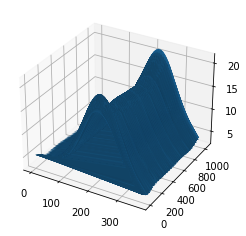

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid[0,:].reshape((len(plot_x), len(plot_y))), grid[1,:].reshape((len(plot_x), len(plot_y))), output.reshape((len(plot_x), len(plot_y))))